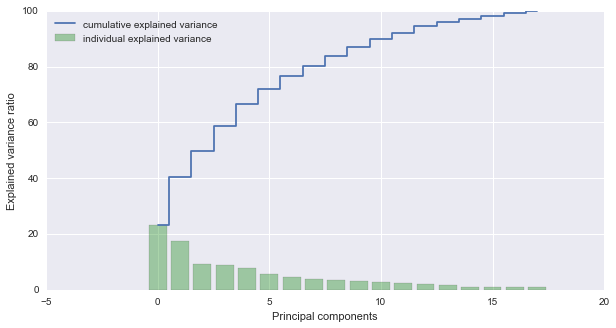

In [1]:
#数据集包含100000条用户电影评分，其中9430被抽出来做测试。
#Collaborative Filtering Systems推荐系统使用Pearson Correlation Similarity Measure寻找相似度最高的用户。
#以下我尝试使用机器学习的聚类算法对电影进行分类；特定用户对特定电影的预测评分将是该用户对该电影所在聚类的均值评分。

import pandas as pd
import numpy as np 
import math 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

%matplotlib inline 


#读取Movies数据
names = ['movie_id','movie_title','release_date','video_release_date',
              'IMDb_URL','unknown','Action','Adventure','Animation',
              'Children','Comedy','Crime','Documentary','Drama','Fantasy', 
              'Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi', 
              'Thriller','War','Western']
movies = pd.read_table('Recommendation_data/u.item', sep='|', header=None, names=names)
movies_genre = movies.ix[:,6:]

#计算Movies类型矩阵的特征值和特征向量
mean_vec = np.mean(movies_genre, axis=0)
cov_mat = np.cov(movies_genre.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

eig_pairs.sort(key = lambda x: x[0], reverse= True)

tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] 
cum_var_exp = np.cumsum(var_exp)

#选取主要成分的维数
plt.figure(figsize=(10, 5))
plt.bar(range(18), var_exp, alpha=0.3333, align='center', label='individual explained variance', color = 'g')
plt.step(range(18), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()


In [2]:
#Movies类型矩阵的维度从18维降至10维可以仍然保留90%的信息量
#应用PCA
movies_genre_array = movies_genre.as_matrix(columns=None)
pca = PCA(n_components=10)
pca.fit(movies_genre_array)
movies_genre_pca = pca.transform(movies_genre_array)
movies_genre_pca[:5]

array([[ 0.80600899,  0.41113697,  0.48581643,  0.1860538 ,  0.39006354,
        -0.67679207,  0.0087999 ,  0.39217085, -0.2794839 ,  0.3694447 ],
       [ 0.34032144, -1.30358194, -0.08145307,  0.13841112, -0.41378311,
        -0.41717544,  0.06387956, -0.06770069,  0.05048498, -0.59779835],
       [ 0.15884273, -0.60255532, -0.08195047, -0.69319401,  0.20785322,
        -0.17105468,  0.17099464,  0.05925162,  0.14633722, -0.12079749],
       [-0.00931359,  0.26418695,  0.12291535,  0.30701683, -1.0959244 ,
        -0.08000186,  0.01655945,  0.31887652, -0.24933984,  0.01903654],
       [-0.67369651, -0.36994271, -0.05823788, -0.80094756, -0.19975073,
        -0.41947847, -0.63914919, -0.27094763, -0.15380729,  0.11432883]])

/Users/edwzhang/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


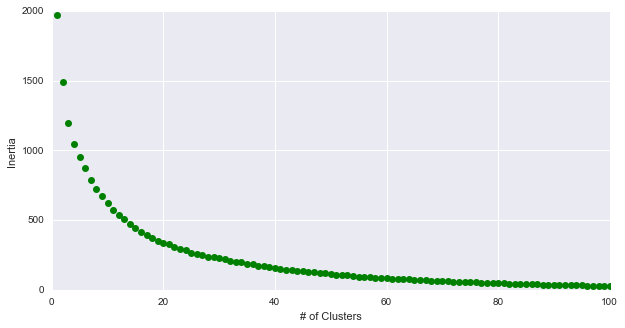

In [3]:
#选取K-Means的聚类族数
x =[]
y =[]
for i in range(100):
    movies_genre_cluster = KMeans(n_clusters=i+1, random_state=0).fit(movies_genre_pca)
    x.append(i+1)
    y.append(movies_genre_cluster.inertia_)
plt.figure(figsize=(10, 5))
plt.plot(x,y, 'go')
plt.ylabel('Inertia')
plt.xlabel('# of Clusters')
plt.legend(loc='best')
plt.show()

In [4]:
#将PCA降维得到的新的Movies类型矩阵应用K-Means划分成50个聚类
movies_genre_cluster = KMeans(n_clusters=50, random_state=0).fit(movies_genre_pca)
movies_genre_cluster.labels_[:5]

array([ 9, 23,  8, 19, 36], dtype=int32)

In [26]:
#读取用户及评分数据并将其与电影数据合并
movies['cluster_id'] = movies_genre_cluster.labels_
names = ['user_id','age','gender','occupation','zip_code']
users = pd.read_table('Recommendation_data/u.user', sep='|', header=None, names=names)

names = ['user_id','movie_id','rating','timestamp']
ratings = pd.read_table('Recommendation_data/u.base', sep='\t', header=None, names=names)

ratings_full = pd.merge(pd.merge(ratings,movies, on='movie_id'), users, on='user_id')

#计算每个用户对其评价过的电影所在聚类的均值矩阵
ratings_by_cluster = ratings_full.pivot_table(values='rating', index=['user_id', 'cluster_id'], aggfunc=np.mean)
ratings_by_cluster[:5]

user_id  cluster_id
1        0             4.230769
         1             3.592593
         2             4.222222
         3             3.500000
         4             1.750000
Name: rating, dtype: float64

In [27]:

names = ['user_id','movie_id','rating','timestamp']
test = pd.read_table('Recommendation_data/u.test', sep='\t', header=None, names=names)

#返回用户对指定电影所在聚类的评分均值。如果用户尚未对指定聚类的任何电影给出评分，则返回NaN
def getAvgRatingByCluster(user_id,movie_id):
    avgRatingByCluster = float((ratings_by_cluster[user_id][movies[movies.movie_id==movie_id].cluster_id]))
    return avgRatingByCluster

#对测试数据计算预测值       
test['avgRatingByCluster'] = test.apply(lambda row: getAvgRatingByCluster(row['user_id'], row['movie_id']), axis=1)
test[:5]

,user_id,movie_id,rating,timestamp,avgRatingByCluster
0,1,20,4,887431883,3.583333
1,1,33,4,878542699,4.000000
2,1,61,4,878542420,4.230769
3,1,117,3,874965739,2.333333
4,1,155,2,878542201,3.000000


In [28]:
#其中有2320条数据为NaN
#对预测值不为空的计算MSE
print len(test[np.isnan(test.avgRatingByCluster)])
print np.sqrt(mean_squared_error(test[~np.isnan(test.avgRatingByCluster)].rating, test[~np.isnan(test.avgRatingByCluster)].avgRatingByCluster))

2320
1.1484145721


In [29]:
#为用户推荐尚未评分的电影。推荐电影来自于用户评分电影所属的电影聚类均分前三名所包含的所有用户尚未单独评分的电影。
ratings_by_cluster_df = pd.DataFrame(ratings_by_cluster)
def recommend_movies(user_id):
    return [list(movies[movies.movie_id==i].movie_title) 
            for i in movies[movies.cluster_id.isin((ratings_by_cluster_df.sort_values(by='rating', axis=0, ascending=False)).ix[user_id,][:3].index.values)].movie_id 
            if len(ratings_full[(ratings_full.user_id==user_id) &(ratings_full.movie_id==i)]) == 0]
    
recommend_movies(10)

/Users/edwzhang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.


[['Net, The (1995)'],
 ['So I Married an Axe Murderer (1993)'],
 ['Akira (1988)'],
 ['Mimic (1997)'],
 ['FairyTale: A True Story (1997)'],
 ['Sphere (1998)'],
 ['Ghost (1990)'],
 ['Close Shave, A (1995)'],
 ['Old Yeller (1957)'],
 ['Parent Trap, The (1961)'],
 ['E.T. the Extra-Terrestrial (1982)'],
 ['To Catch a Thief (1955)'],
 ['Another Stakeout (1993)'],
 ['Body Snatchers (1993)'],
 ['Secret Garden, The (1993)'],
 ['So Dear to My Heart (1949)'],
 ['Arsenic and Old Lace (1944)'],
 ['Body Snatchers (1993)'],
 ['Dark City (1998)'],
 ['Fluke (1995)'],
 ['Lawnmower Man 2: Beyond Cyberspace (1996)'],
 ['Bogus (1996)'],
 ['Unforgettable (1996)'],
 ['Island of Dr. Moreau, The (1996)'],
 ['Charade (1963)'],
 ['Head Above Water (1996)'],
 ['Shiloh (1997)'],
 ['Little Princess, A (1995)'],
 ['Kim (1950)'],
 ['Virtuosity (1995)'],
 ['Robocop 3 (1993)'],
 ['Little Princess, The (1939)'],
 ['Tainted (1998)']]

In [30]:
#与皮尔逊相关PCS的对比
def pcs(user_1,user_2):
    m1 = ratings_full[ratings_full.user_id==user_1].movie_id
    m2 = ratings_full[ratings_full.user_id==user_2].movie_id
    l = list(set(m1).intersection(set(m2)))
    
    user1_avg = float(np.mean(list(ratings_full[ratings_full.user_id==user_1].rating)))
    user2_avg = float(np.mean(list(ratings_full[ratings_full.user_id==user_2].rating)))
    
    numerator = 0.0
    denominator1 = 0.0
    denominator2 = 0.0

    for i in l:
        r_1_i = float(ratings_full[(ratings_full.user_id==user_1) & (ratings_full.movie_id ==i)].rating)
        r_2_i = float(ratings_full[(ratings_full.user_id==user_2) & (ratings_full.movie_id ==i)].rating)
        numerator = numerator + (r_1_i - user1_avg)*(r_2_i - user2_avg)
        denominator1 = denominator1 + np.square(r_1_i - user1_avg)
        denominator2 = denominator2 + np.square(r_2_i - user2_avg)
    pcs = numerator/np.sqrt(denominator1)*np.sqrt(denominator2)
    return pcs


def getAvgRatingByPCS(user_id, movie_id, top=5):
    pcs_list = []
    for i in set(ratings_full.user_id):
        if i != user_id:
            pcs_i = pcs(user_id, i)
            if not math.isnan(pcs_i):
                pcs_list.append([i, pcs_i])
                
    top_pcs = sorted(pcs_list, key=lambda x:x[1], reverse=True)[:top]

    avgRatingByPCS = 0.0
    cnt = 0
    for i in range(top):
        pcs_rating= ratings_full[(ratings_full.user_id==top_pcs[i][0]) & (ratings_full.movie_id ==movie_id)].rating
        if len(pcs_rating) >0:
            avgRatingByPCS = avgRatingByPCS + float(pcs_rating)
            cnt = cnt+1
    if cnt != 0:
        avgRatingByPCS = avgRatingByPCS/cnt
    
    return avgRatingByPCS

print getAvgRatingByPCS(1,202)
print getAvgRatingByCluster(1,202)


4.4
3.76923076923


In [ ]:
#几点小结
#1. PCA加K-Means聚类得到最终预测评分并没有好于PCS。（MSE 1.15>1.06）
#2. 原因出在PCA丢失了信息？K-Means的聚类数量不够理想？
#3. 面对2320条NaN数据，可否用PCS的预测值，综合性能是否会好于单独PCS？
#4. 可否对用户+电影+评分一起进行聚类？
#5. 可否用监督学习来预测评分？性能会更好？